
Link to the google drive folder where all the datasets were downloaded and stored: Download on your local drive[It will be a zipped file]. Exract the folder after downloading and then upload the folder on your drive again.

https://drive.google.com/drive/folders/1vQ0GO0L-FbHJ1cgSVlzFqHgXYF_j53SI?usp=sharing

## **Importing all the required Libraries**

In [1]:
# Importing Libraries

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# **A function to take all datasets as input.**

In [2]:
# A function to take all datasets as input

def input_dfs(sensor_placement):
  walk=[]
  run=[]
  up=[]
  down=[]
  for i in range(1,16):
    wal_t=pd.read_csv('/content/drive/MyDrive/Project2/sub'+str(i)+'/acc_walking_csv/acc_walking_'+sensor_placement+'.csv')
    run_t=pd.read_csv('/content/drive/MyDrive/Project2/sub'+str(i)+'/acc_running_csv/acc_running_'+sensor_placement+'.csv')
    up_t=pd.read_csv('/content/drive/MyDrive/Project2/sub'+str(i)+'/acc_climbingup_csv/acc_climbingup_'+sensor_placement+'.csv')
    down_t=pd.read_csv('/content/drive/MyDrive/Project2/sub'+str(i)+'/acc_climbingdown_csv/acc_climbingdown_'+sensor_placement+'.csv')
    walk.append(wal_t)
    run.append(run_t)
    up.append(up_t)
    down.append(down_t)
  return(walk,run,up,down)

In [3]:
# Calling the above function and storing the datasets in chest and head lists

sensors=['chest','head']
chest=[]
head=[]
for sens in sensors:
  w,r,u,d=input_dfs(sens)
  if(sens=='chest'):
    if(len(chest)>=4):
      break
    chest.append(w)
    chest.append(r)
    chest.append(u)
    chest.append(d)
  else:
    if(len(head)>=4):
      break
    head.append(w)
    head.append(r)
    head.append(u)
    head.append(d)

# **Functions to calculate Permutation Entropy and Complexity for all time-series data using ordinal patters[ Created by:  Randhakrishnam sir]**

In [4]:
# Code from Radhakrishnan sir's gith-hub repository to calculate Permutation Entropy and Complexity by generating ordinal patterns of time-series

def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*m-1):, :] 
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:]) 
    

def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*m-1):, :] 
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0])

# **Function to get the the time-series from outlist of datasets corresponding to a given signal-length, Embedded dimension , time delay and accelerometer axis.**

In [5]:
# Function to get the the time-series from outlist of datasets corresponding to a given signal-length, Embedded dimension , time delay and accelerometer axis.

def getting_ts(df,sig_len,dim,delay,axis):
  ts=df[axis][1000:(1001+sig_len)]
  op=weighted_ordinal_patterns(ts,dim,delay)
  pe=p_entropy(op)
  comp=complexity(op)
  out=[axis,sig_len,dim,delay,pe,comp]
  return(out)


# **Creating an empty dataframe with column names for output storage.**

In [6]:
out_df=pd.DataFrame(columns=['Sensor_Placement','Subject' ,'Accelerometer_axis','Signal_Length','Embedded_Dimension','Delay','Permutation_entropy','Complexity','Activity'])
out_df

,Sensor_Placement,Subject,Accelerometer_axis,Signal_Length,Embedded_Dimension,Delay,Permutation_entropy,Complexity,Activity


# **Functions calling the "getting-ts" function and other above functions for calculating its corresponding Permutation entropy and Complexity.**

In [7]:
# A code calling the "getting-ts" function and other above functions for calculating its corresponding Permutation entropy and Complexity.

def table_generation(l,body_part):
  wa=l[0].copy()
  ru=l[1].copy()
  u_p=l[2].copy()
  d_o=l[3].copy()
  activity=["Walking","Running","Climbing Up","Climbing Down"]
  cols=['attr_x','attr_y','attr_z']
  signal_length=[1024,2048,4096]
  dimensions=[3,4,5,6]
  delay=[1,2,3]
  for i in range(1,16):
    sub='Subject'+str(i)
    sub_all=[wa[i-1],ru[i-1],u_p[i-1],d_o[i-1]]
    for j in range(len(activity)):
      for ax in cols:
        for sig_len in signal_length:
          for dim in dimensions:
            for dela in delay:
              out_row=getting_ts(sub_all[j],sig_len,dim,dela,ax)
              out_row.append(activity[j])
              out_row.insert(0,body_part)
              out_row.insert(1,sub)
              out_df.loc[len(out_df)] =out_row

In [8]:
table_generation(chest,'Chest')

In [9]:
table_generation(head,'Head')

# **Filled output dataframe.**

In [10]:
out_df

,Sensor_Placement,Subject,Accelerometer_axis,Signal_Length,Embedded_Dimension,Delay,Permutation_entropy,Complexity,Activity
0,Chest,Subject1,attr_x,1024,3,1,0.693623,0.215161,Walking
1,Chest,Subject1,attr_x,1024,3,2,0.935981,0.058802,Walking
2,Chest,Subject1,attr_x,1024,3,3,0.932515,0.064523,Walking
3,Chest,Subject1,attr_x,1024,4,1,0.679300,0.278795,Walking
4,Chest,Subject1,attr_x,1024,4,2,0.872240,0.145609,Walking
...,...,...,...,...,...,...,...,...,...
12955,Head,Subject15,attr_z,4096,5,2,0.831042,0.213559,Climbing Down
12956,Head,Subject15,attr_z,4096,5,3,0.847541,0.214291,Climbing Down
12957,Head,Subject15,attr_z,4096,6,1,0.786673,0.295279,Climbing Down
12958,Head,Subject15,attr_z,4096,6,2,0.818157,0.289861,Climbing Down


# **Plotting the required scatter plots for "Running Vs Walking" and "Climbing Up Vs Climbing Down" for different dimensions as mentioned below. We get 48 different scatter plots.**

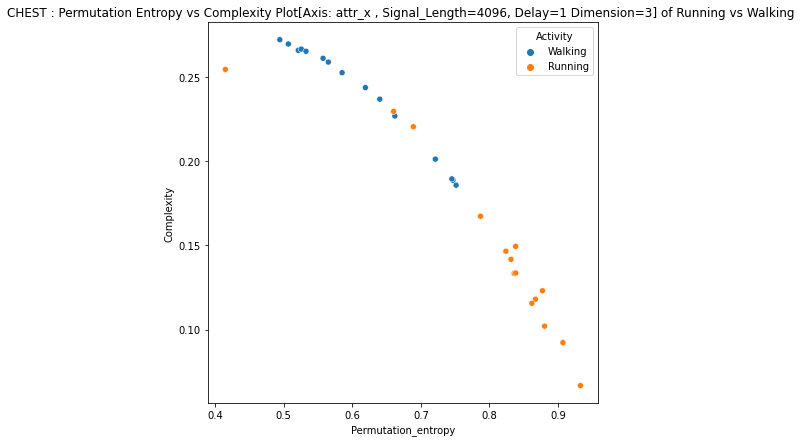

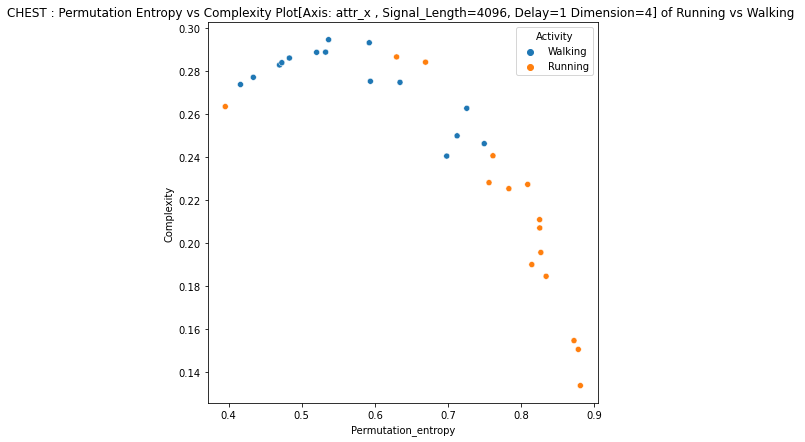

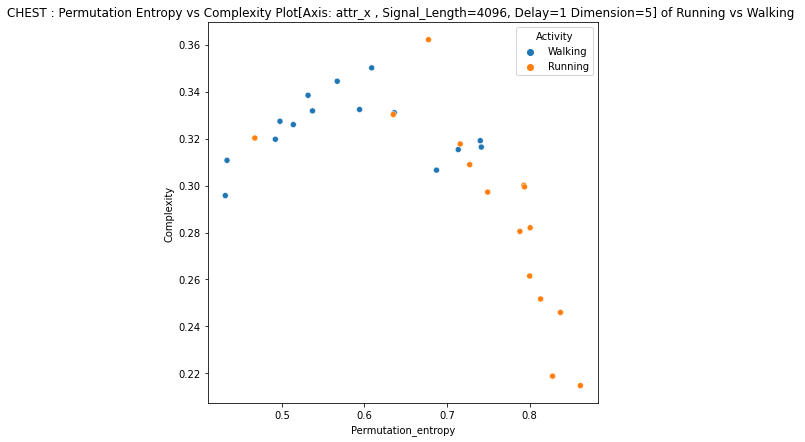

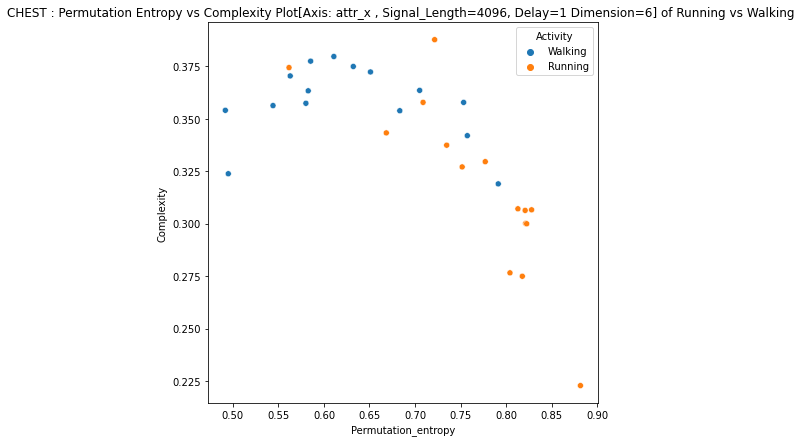

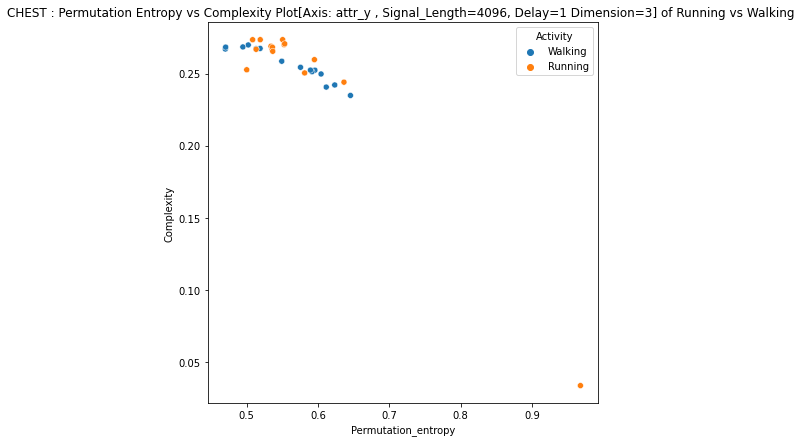

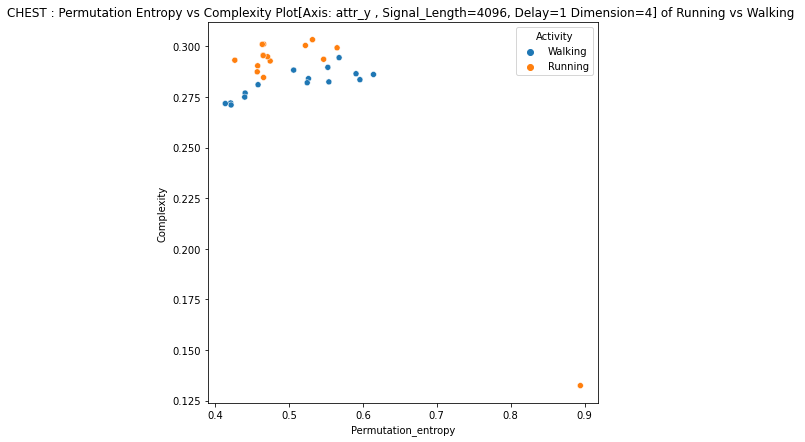

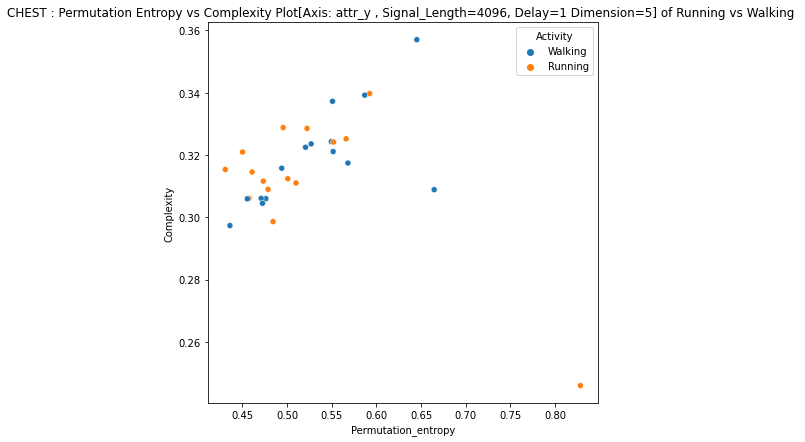

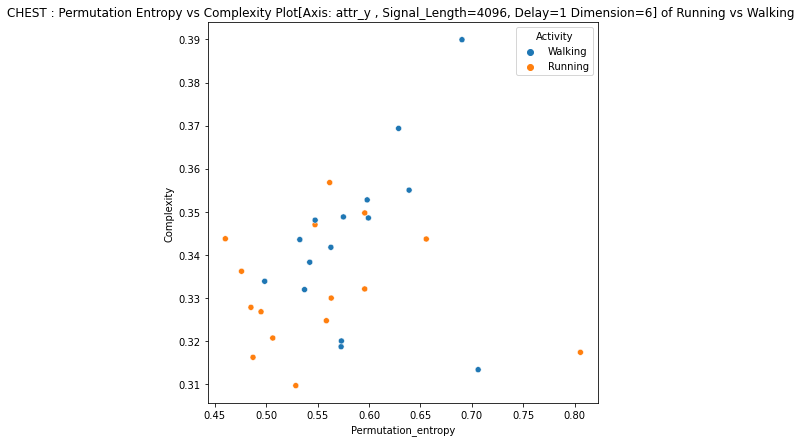

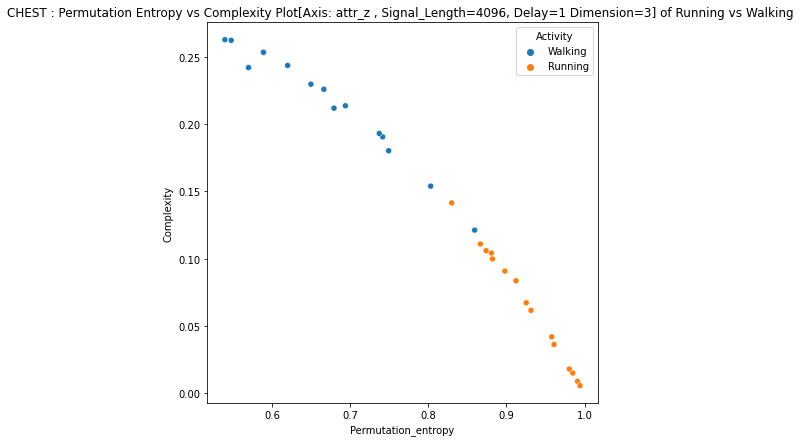

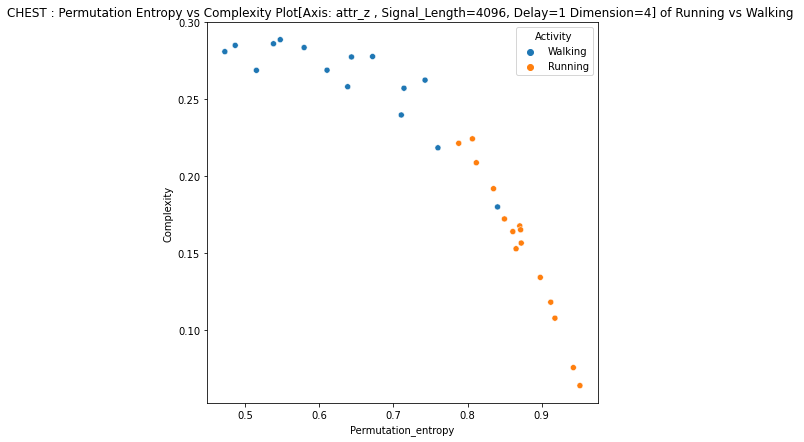

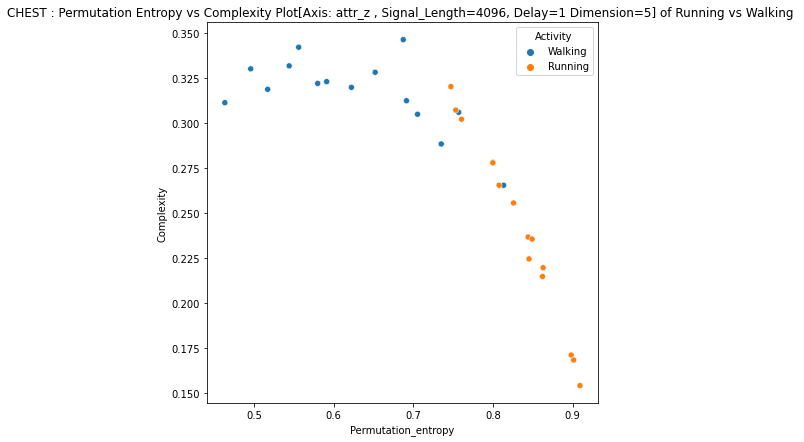

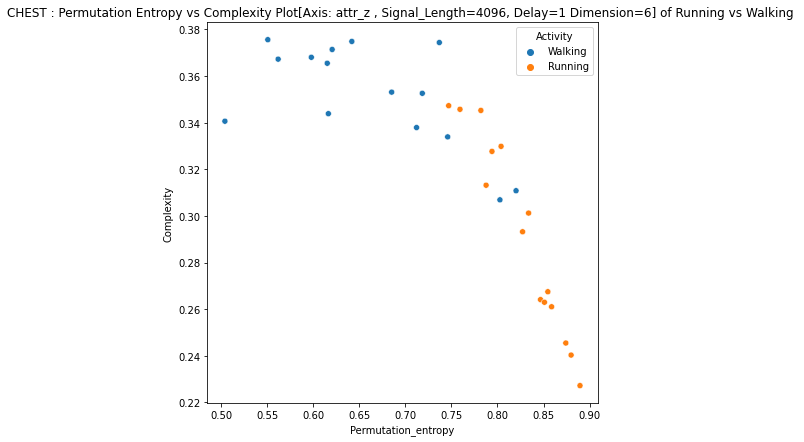

In [18]:
# Chest --Running Vs Walking -- Permutation Entropy vs Complexity -- All three axes -- Dimesnsions=[3,4,5,6] --- Signal Length=4096 -- Delay=1

df_run_wal_chest=out_df[((out_df['Activity']=='Walking') | (out_df['Activity']=='Running')) & (out_df['Signal_Length']==4096) & (out_df['Sensor_Placement']=='Chest') & (out_df['Delay']==1) ]
axes=['attr_x','attr_y','attr_z']
dimensions=[3,4,5,6]
for ax in axes:
  for dim in dimensions:
    df_temp=df_run_wal_chest[(df_run_wal_chest['Accelerometer_axis']==ax) & (df_run_wal_chest['Embedded_Dimension']==dim)]
    fig=plt.figure(figsize=(7,7))
    sns.scatterplot(x='Permutation_entropy', y='Complexity', data=df_temp, hue='Activity').set(title='CHEST : Permutation Entropy vs Complexity Plot[Axis: '+ax+' , Signal_Length=4096, Delay=1 Dimension='+str(dim)+'] of Running vs Walking ')

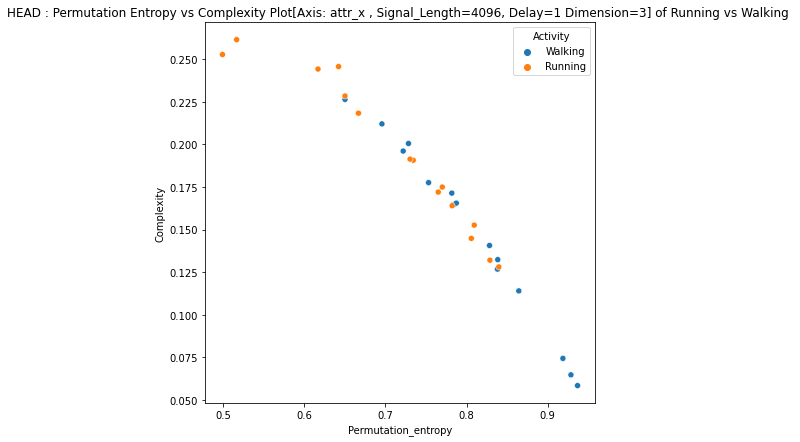

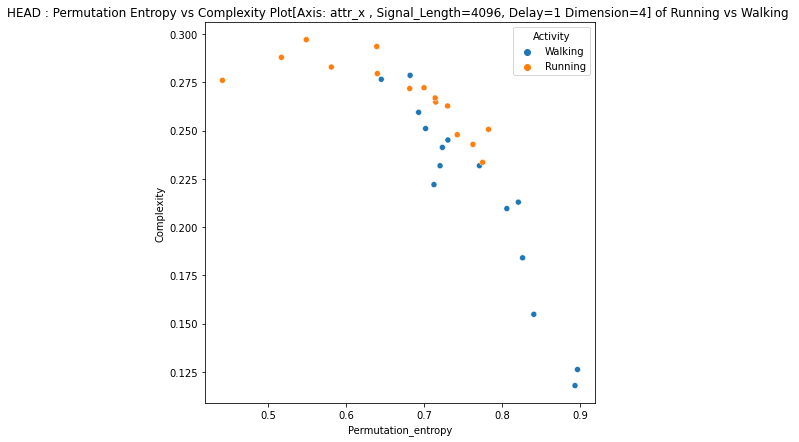

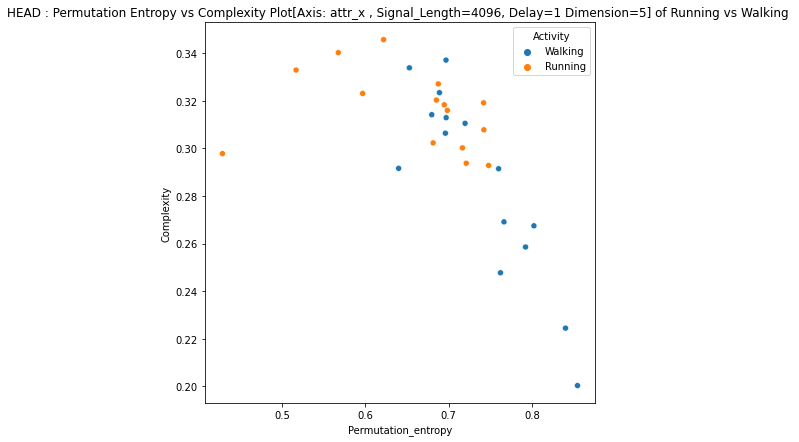

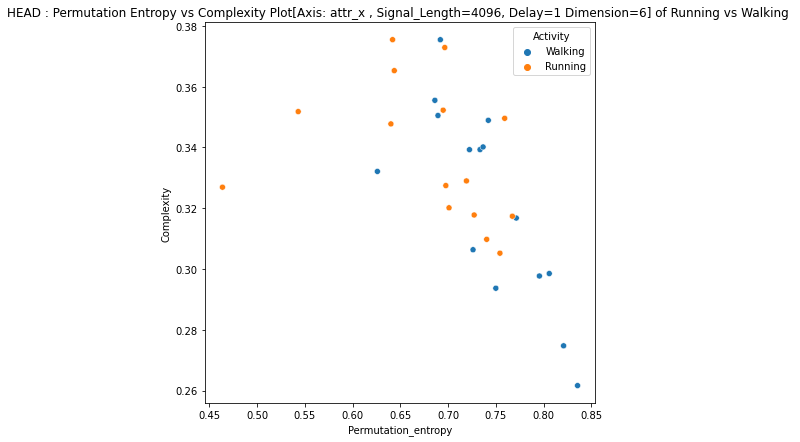

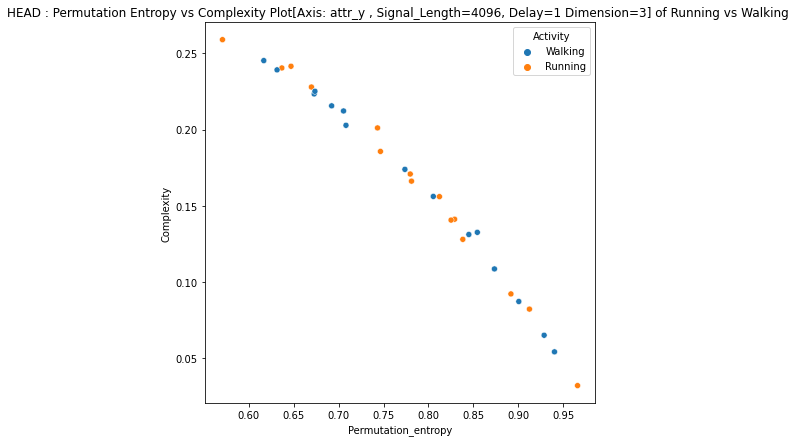

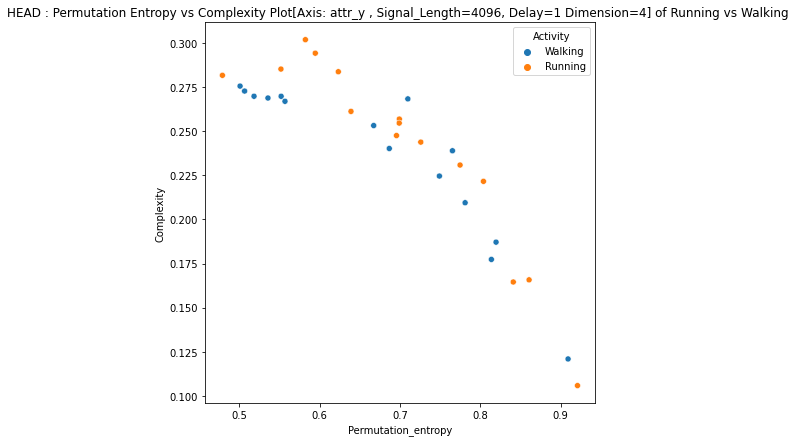

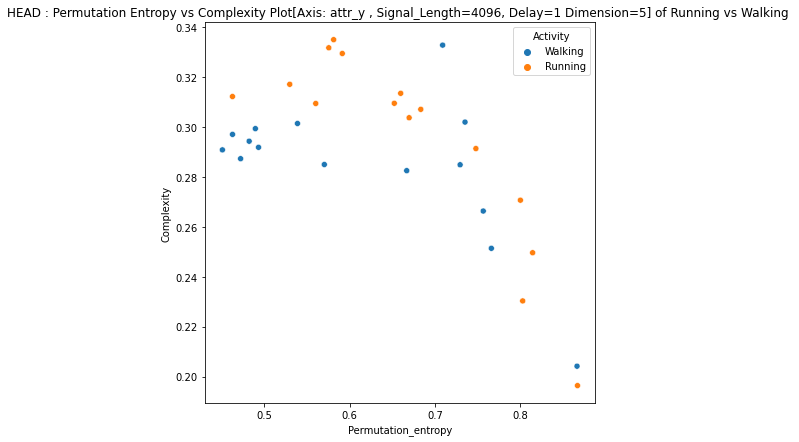

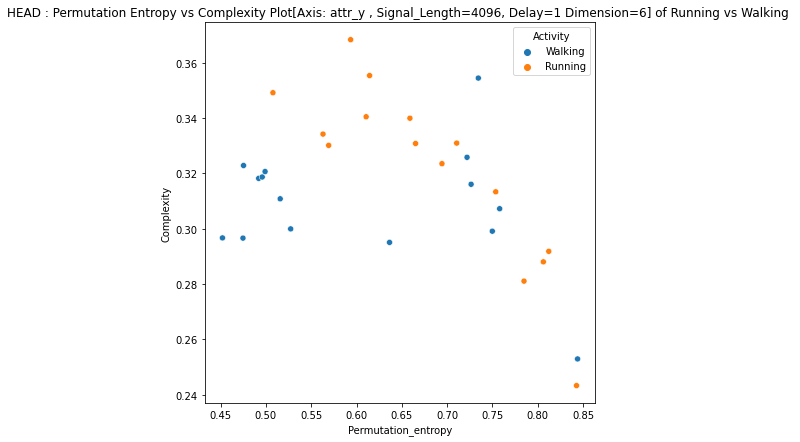

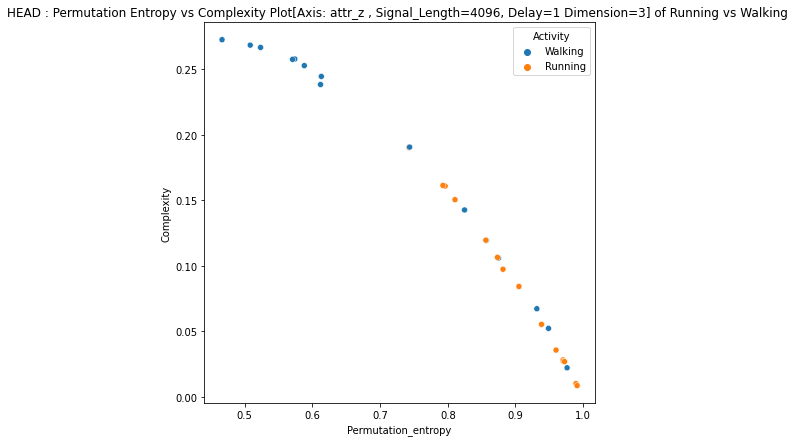

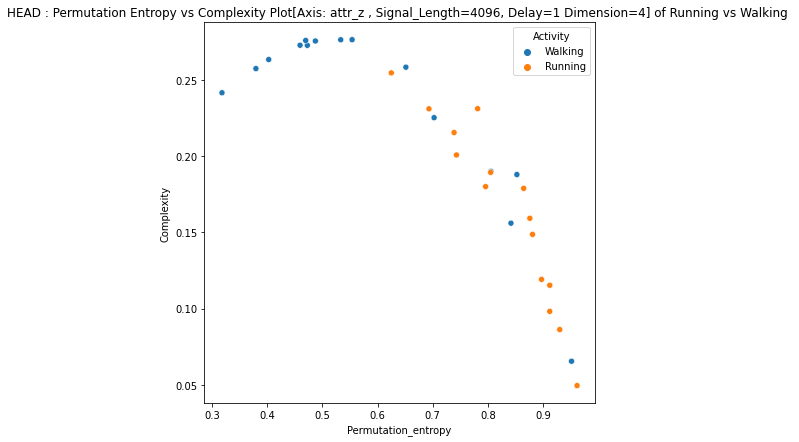

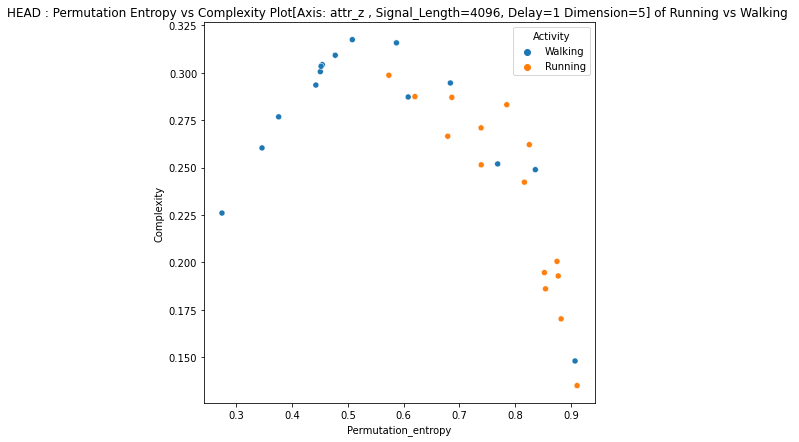

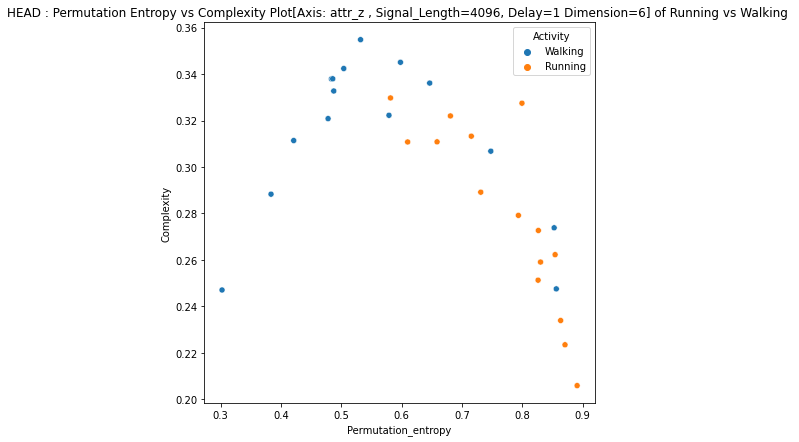

In [15]:
# Head --Running Vs Walking -- Permutation Entropy vs Complexity -- All three axes -- Dimesnsions=[3,4,5,6] --- Signal Length=4096 -- Delay=1

df_run_wal_chest=out_df[((out_df['Activity']=='Walking') | (out_df['Activity']=='Running')) & (out_df['Signal_Length']==4096) & (out_df['Sensor_Placement']=='Head') & (out_df['Delay']==1) ]
axes=['attr_x','attr_y','attr_z']
dimensions=[3,4,5,6]
for ax in axes:
  for dim in dimensions:
    df_temp=df_run_wal_chest[(df_run_wal_chest['Accelerometer_axis']==ax) & (df_run_wal_chest['Embedded_Dimension']==dim)]
    fig=plt.figure(figsize=(7,7))
    sns.scatterplot(x='Permutation_entropy', y='Complexity', data=df_temp, hue='Activity').set(title='HEAD : Permutation Entropy vs Complexity Plot[Axis: '+ax+' , Signal_Length=4096, Delay=1 Dimension='+str(dim)+'] of Running vs Walking ')

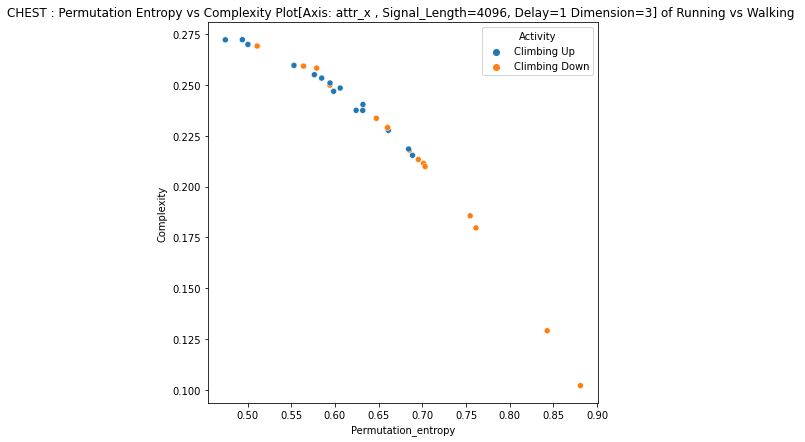

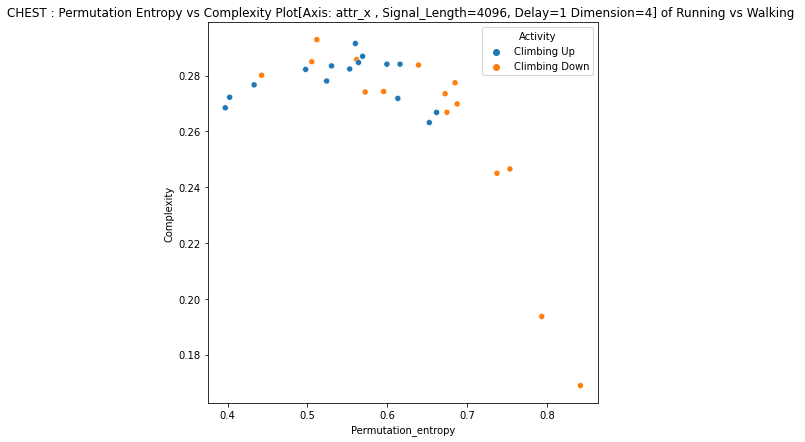

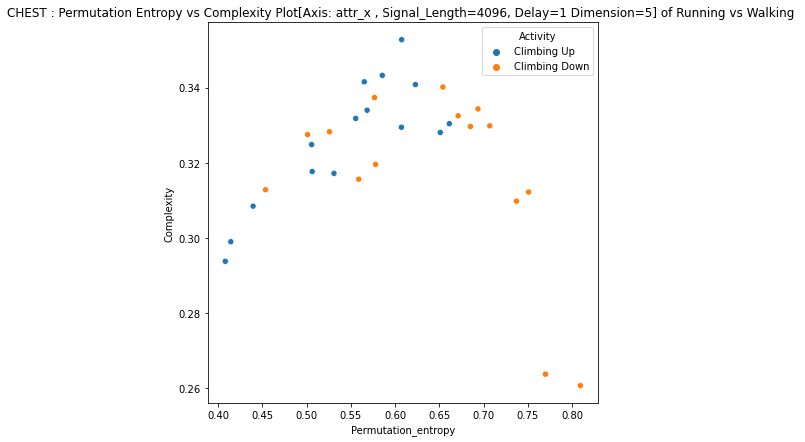

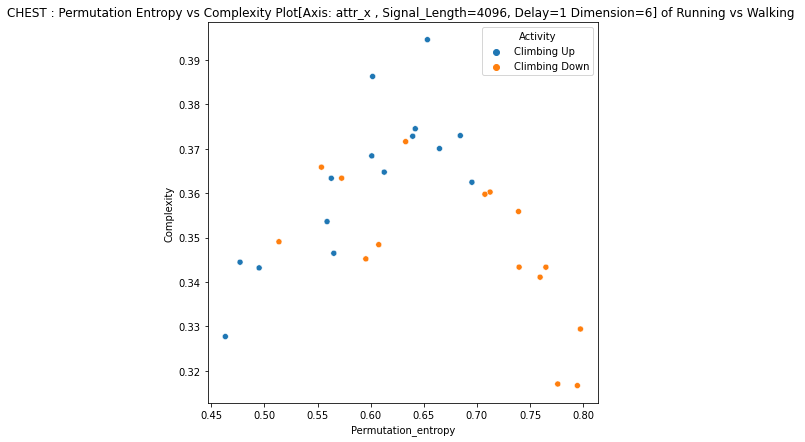

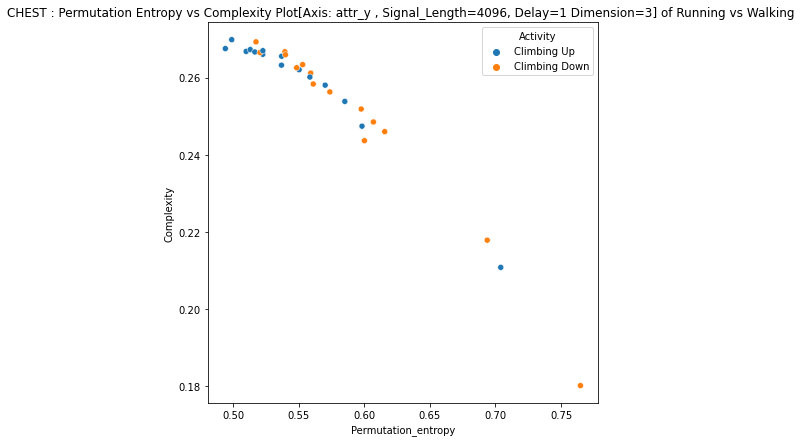

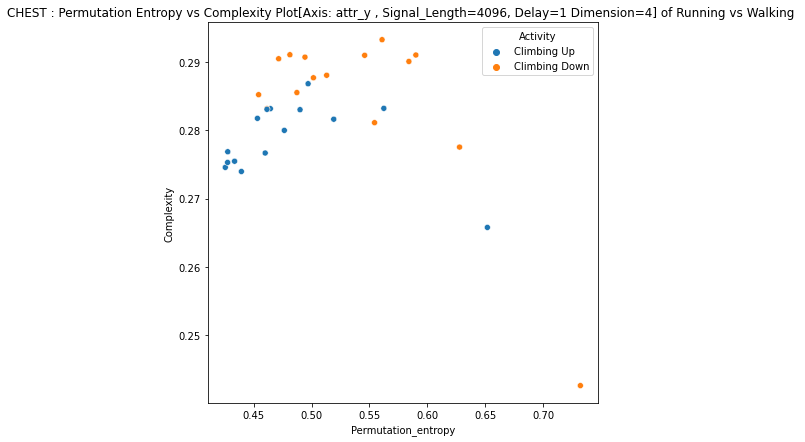

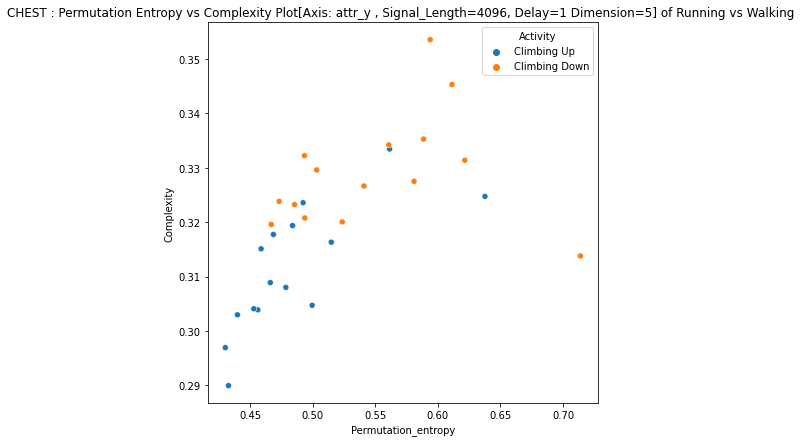

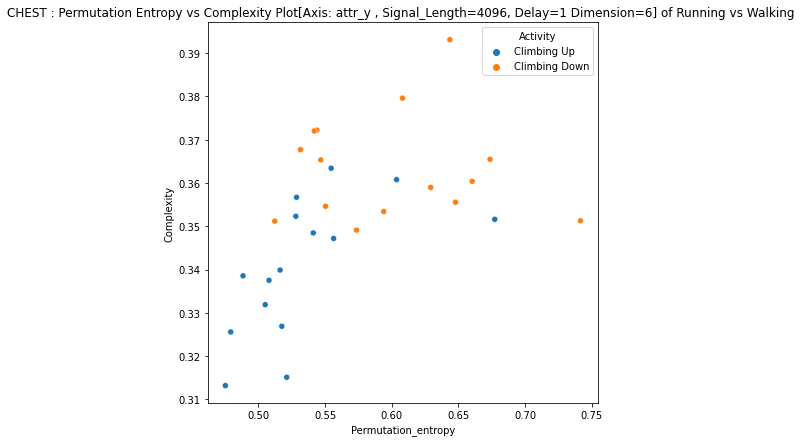

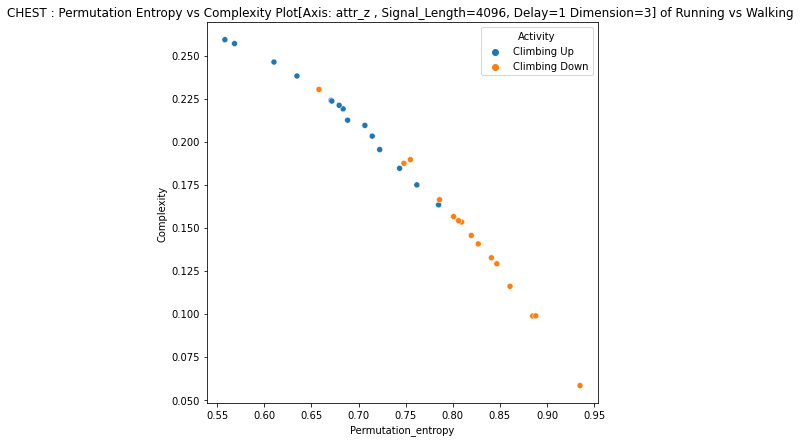

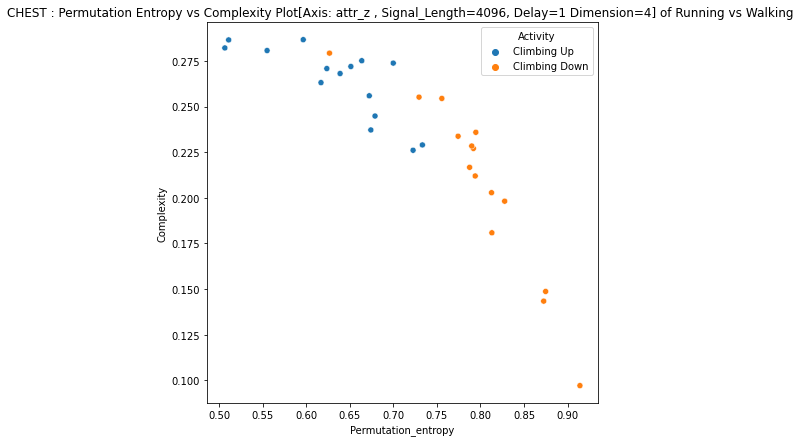

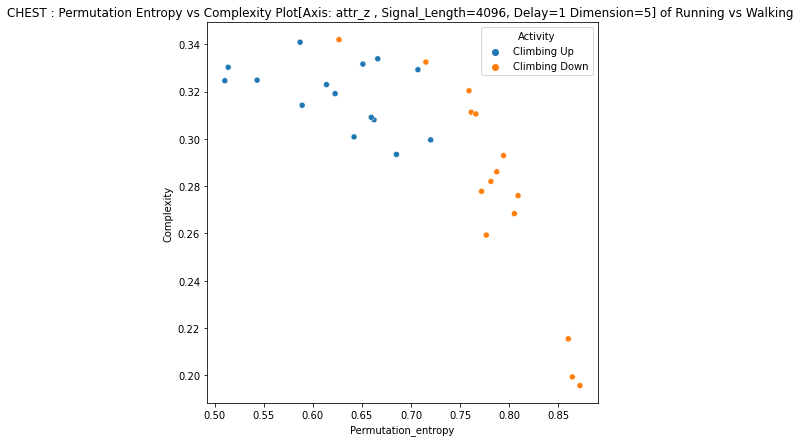

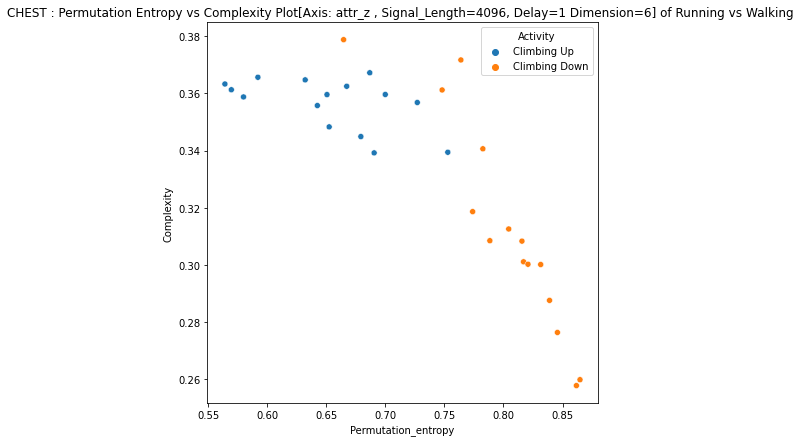

In [16]:
# Chest --Climbing Up Vs Climbing Down -- Permutation Entropy vs Complexity -- All three axes -- Dimesnsions=[3,4,5,6] --- Signal Length=4096 -- Delay=1

df_run_wal_chest=out_df[((out_df['Activity']=='Climbing Down') | (out_df['Activity']=='Climbing Up')) & (out_df['Signal_Length']==4096) & (out_df['Sensor_Placement']=='Chest') & (out_df['Delay']==1) ]
axes=['attr_x','attr_y','attr_z']
dimensions=[3,4,5,6]
for ax in axes:
  for dim in dimensions:
    df_temp=df_run_wal_chest[(df_run_wal_chest['Accelerometer_axis']==ax) & (df_run_wal_chest['Embedded_Dimension']==dim)]
    fig=plt.figure(figsize=(7,7))
    sns.scatterplot(x='Permutation_entropy', y='Complexity', data=df_temp, hue='Activity').set(title='CHEST : Permutation Entropy vs Complexity Plot[Axis: '+ax+' , Signal_Length=4096, Delay=1 Dimension='+str(dim)+'] of Running vs Walking ')

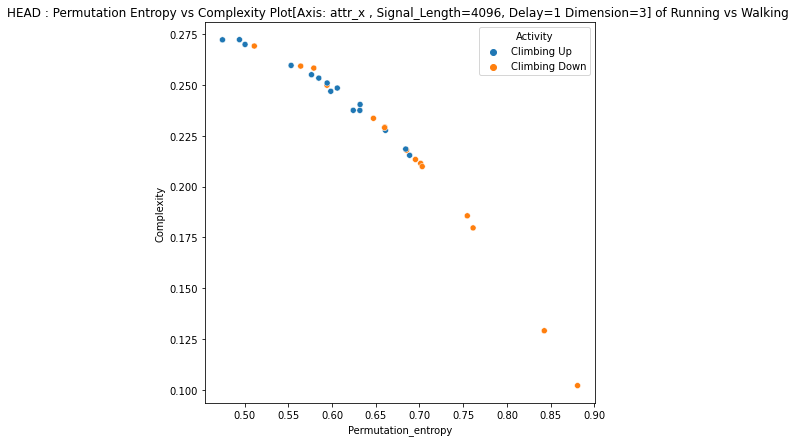

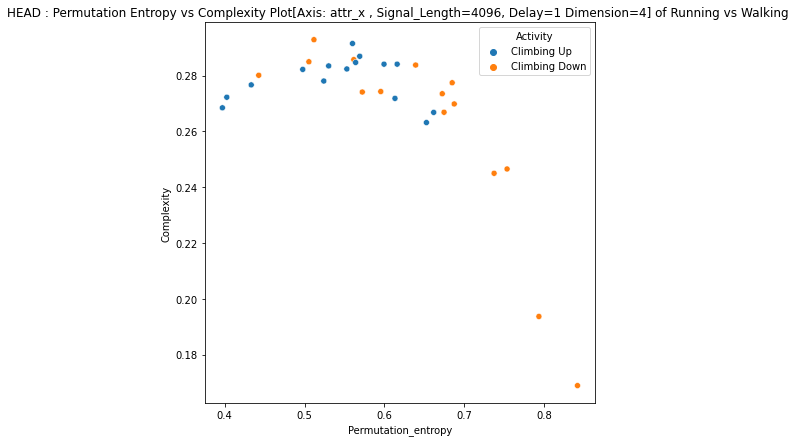

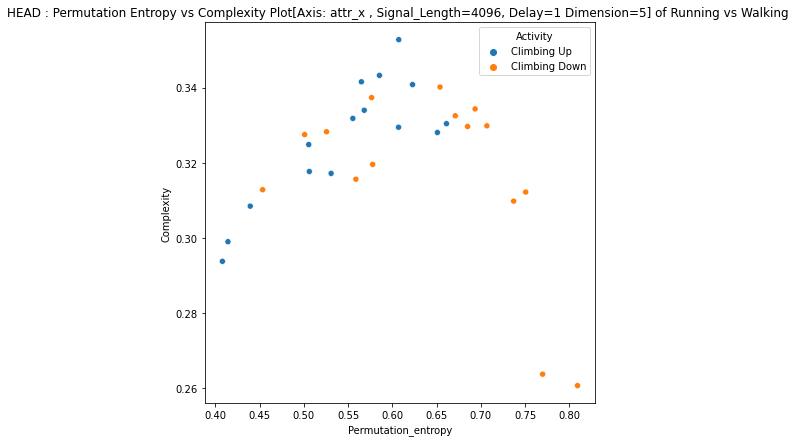

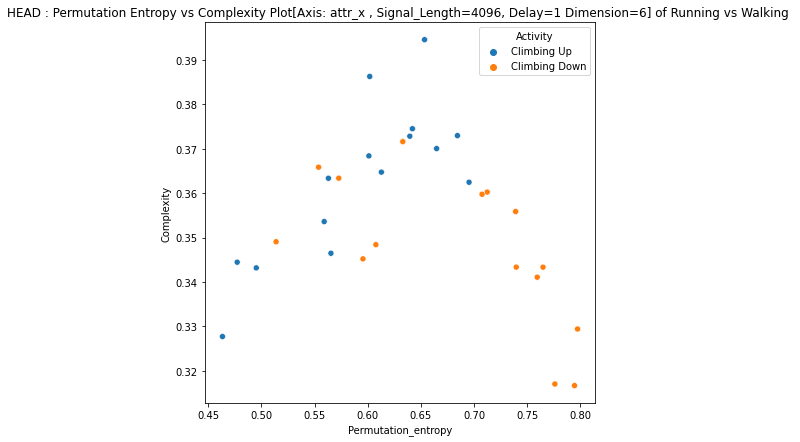

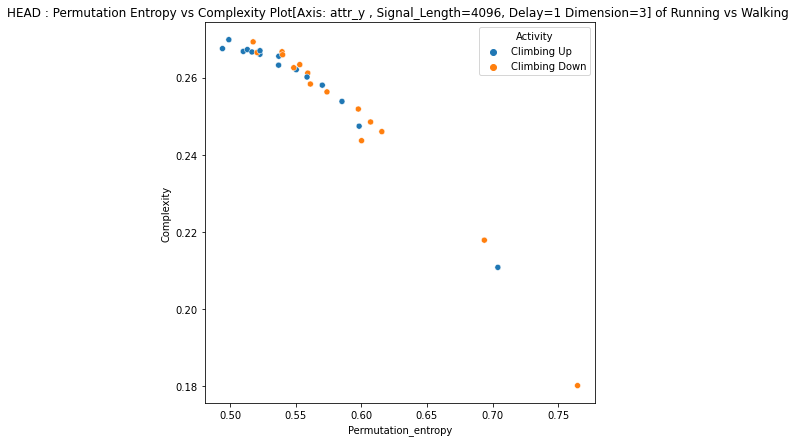

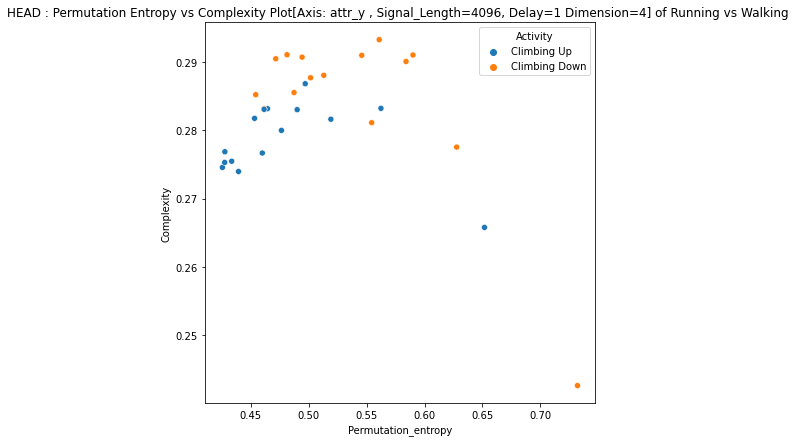

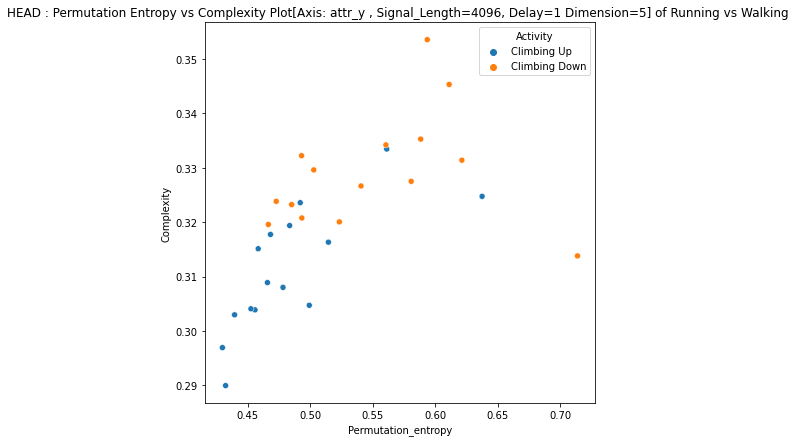

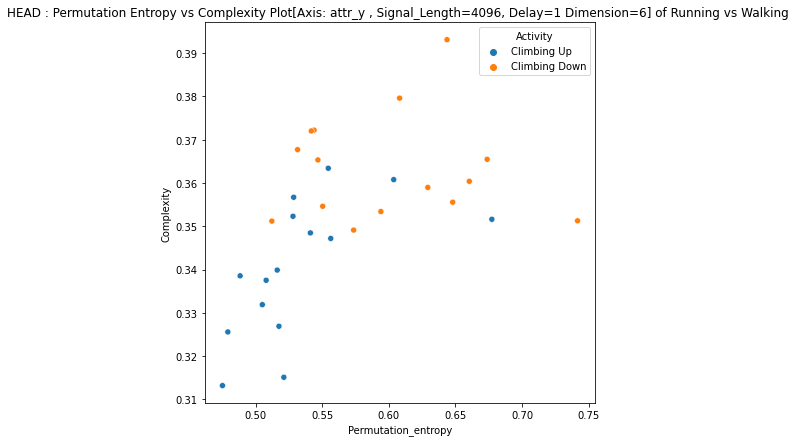

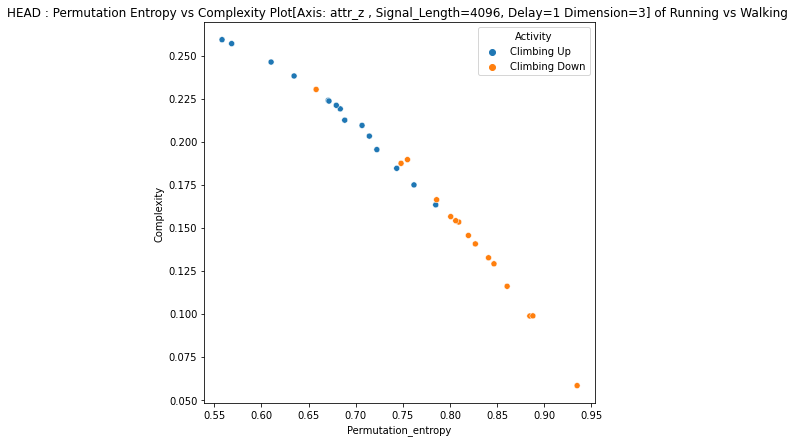

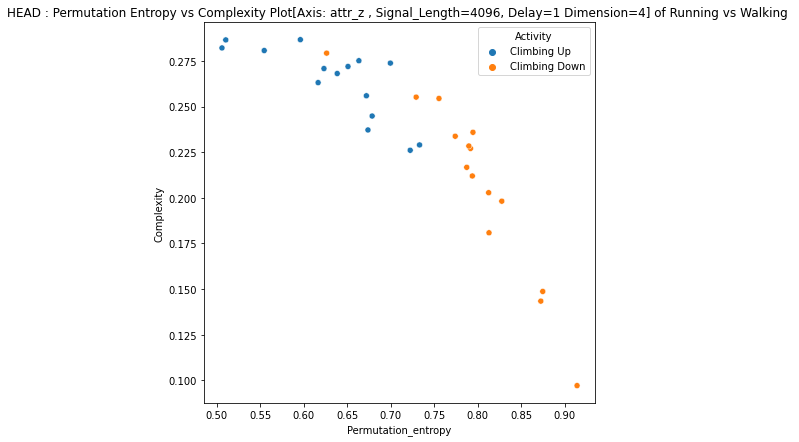

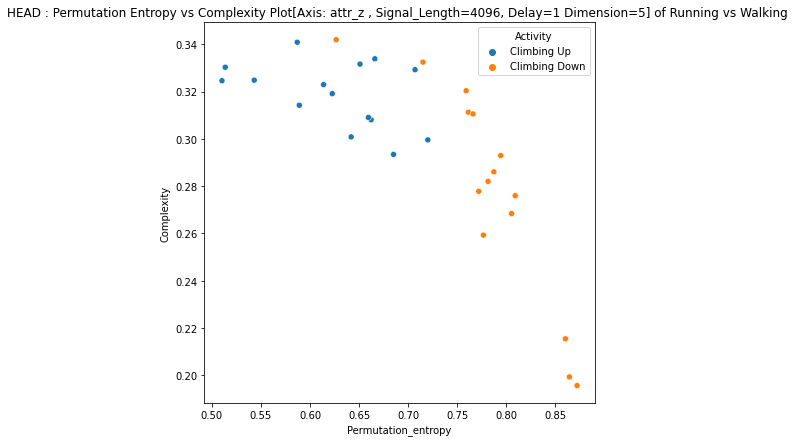

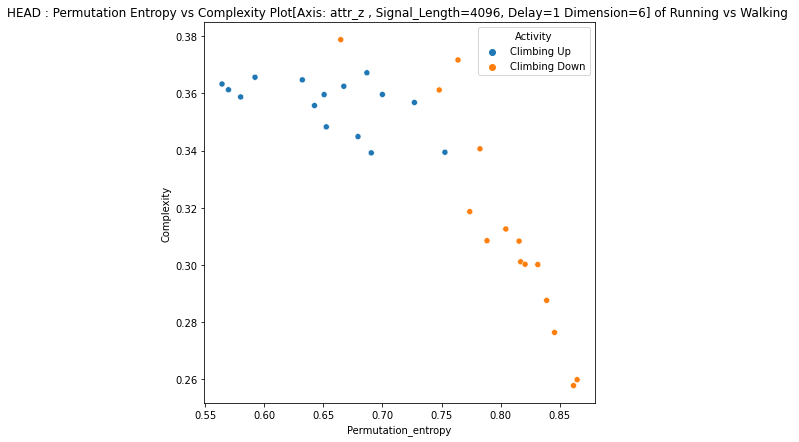

In [17]:
# Head --Climbing Up Vs Climbing Down -- Permutation Entropy vs Complexity -- All three axes -- Dimesnsions=[3,4,5,6] --- Signal Length=4096 -- Delay=1

df_run_wal_chest=out_df[((out_df['Activity']=='Climbing Down') | (out_df['Activity']=='Climbing Up')) & (out_df['Signal_Length']==4096) & (out_df['Sensor_Placement']=='Chest') & (out_df['Delay']==1) ]
axes=['attr_x','attr_y','attr_z']
dimensions=[3,4,5,6]
for ax in axes:
  for dim in dimensions:
    df_temp=df_run_wal_chest[(df_run_wal_chest['Accelerometer_axis']==ax) & (df_run_wal_chest['Embedded_Dimension']==dim)]
    fig=plt.figure(figsize=(7,7))
    sns.scatterplot(x='Permutation_entropy', y='Complexity', data=df_temp, hue='Activity').set(title='HEAD : Permutation Entropy vs Complexity Plot[Axis: '+ax+' , Signal_Length=4096, Delay=1 Dimension='+str(dim)+'] of Running vs Walking ')